In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom #pip install pydicom
import cv2 #pip install opencv-python
import tensorflow as tf
import shutil

In [18]:
pydicom.__version__
tf.__version__# 要用2.0以上的版本

'2.12.0-rc1'

# 数据预处理

## 数据读取

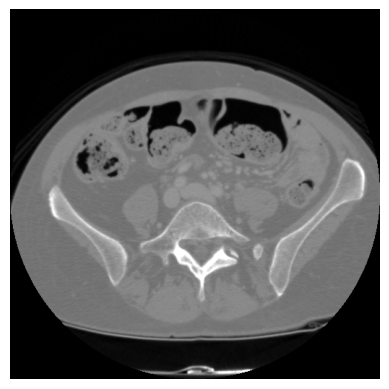

In [19]:
data_path = r'./3Dircadb1/3Dircadb1.1/PATIENT_DICOM'
#读取单张图片
img = pydicom.dcmread(os.path.join(data_path,'image_0'))
plt.imshow(img.pixel_array,cmap='gray')#灰度图
plt.axis('off')#去掉坐标轴
plt.show()

In [20]:
#批量数据读取
image_slices = [pydicom.dcmread(os.path.join(data_path,file_name)) for file_name in os.listdir(data_path)]
os.listdir(data_path)#预设按照字元排序，顺序乱掉了
#重新排序,避免CT图乱序
image_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
#提取图元值
image_array = np.array([i.pixel_array for i in image_slices])

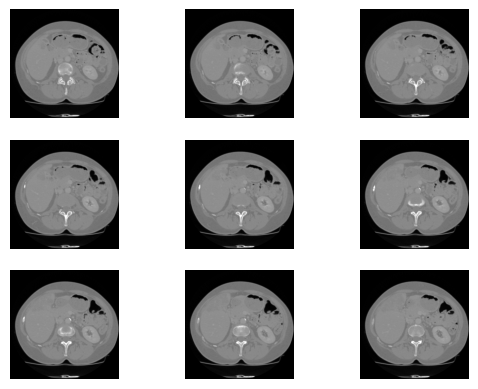

In [21]:
#视觉化展示读取的数据
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(image_array[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## CT图增强-windowing

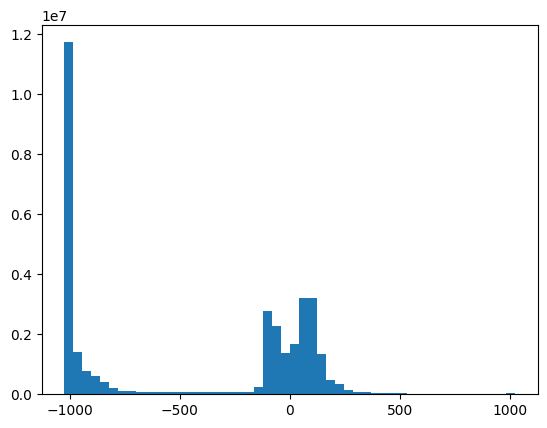

In [22]:
plt.hist(image_array.reshape(-1,),bins=50)
plt.show()

In [2]:
#给定windowing自定函數
def windowing(img, window_width, window_center):
    #img： 需要增强的图片
    #window_width:窗宽
    #window_center:中心
    minWindow = float(window_center)-0.5*float(window_width)
    new_img = (img-minWindow)/float(window_width)
    new_img[new_img<0] = 0
    new_img[new_img>1] = 1
    return (new_img*255).astype('uint8') #把资料整理成标准图像格式

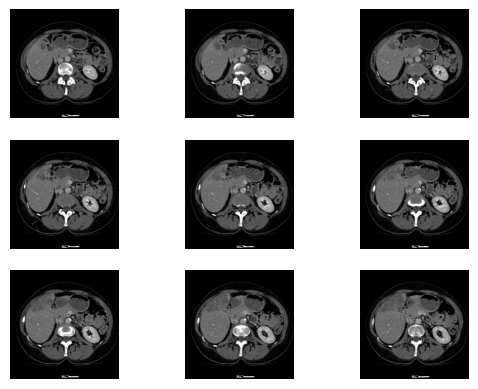

In [24]:
img_ct = windowing(image_array,500,150)
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(img_ct[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

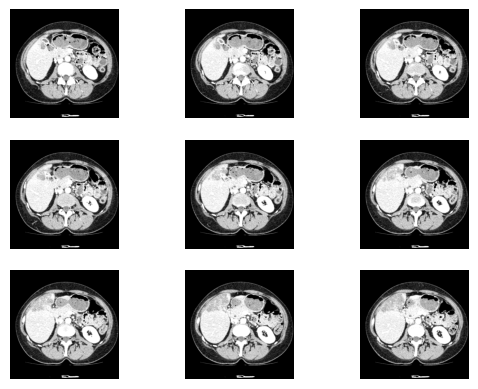

In [25]:
img_ct = windowing(image_array,250,0)
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(img_ct[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## 长条图均衡化

In [3]:
# img_ct.shape
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize= (8,8))
# clahe.apply(img_ct[0])#一次只能处理一张图片
#自定批量均衡化函數
def clahe_equalized(imgs):
    #输入imgs的形狀必须是3维的 （129,512,512）
    assert(len(imgs.shape ) == 3)
    #定义均衡化函數
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize= (8,8))
    #新矩阵用来存放均衡化后的资料
    img_res = np.zeros_like(imgs)
    for i in range(len(imgs)):
        img_res[i,:,:] = clahe.apply(np.array(imgs[i,:,:],dtype=np.uint8))
    return img_res/255.0

In [27]:
img_clahe = clahe_equalized(img_ct)

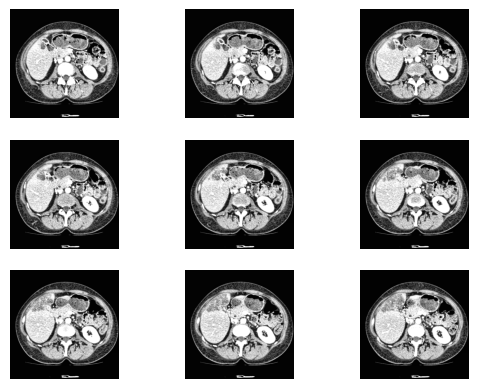

In [28]:
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(img_clahe[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## 提取肿瘤部位的CT图和掩模图


In [29]:
#只用一个肿瘤示范
data_path_mask = r'./3Dircadb1/3Dircadb1.1/MASKS_DICOM/livertumor01'
#批量数据读取
tumor_slices = [pydicom.dcmread(os.path.join(data_path_mask,file_name)) for file_name in os.listdir(data_path)]
#重新排序,避免CT图乱序
tumor_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
#提取图元值
tumor_array = np.array([i.pixel_array for i in tumor_slices])

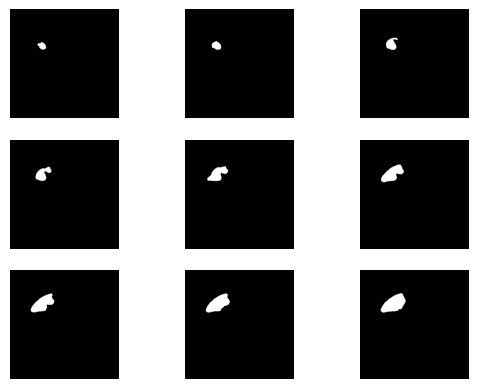

In [30]:
#视觉化展示读取的数据
j = 1
for i in range(51,60):
    plt.subplot(3,3,j)
    plt.imshow(tumor_array[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

In [31]:
#沒有肿瘤的掩模图全部是黑色,对应的图元矩阵全为0
index = [i.sum()>0  for i in tumor_array] #提取含肿瘤部分
#提取掩模图的肿瘤部分
img_tumor = tumor_array[index]
#对增強后的CT图提取肿瘤部分
img_patient = img_clahe[index]

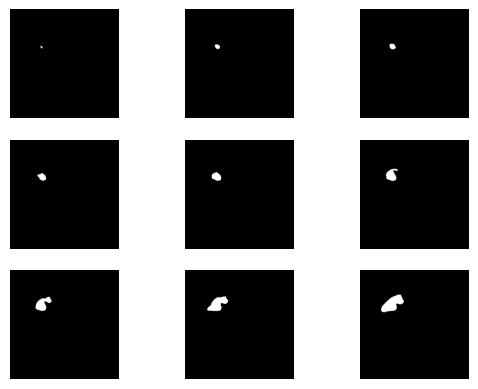

In [32]:
#视觉化展示读取的数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(img_tumor[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

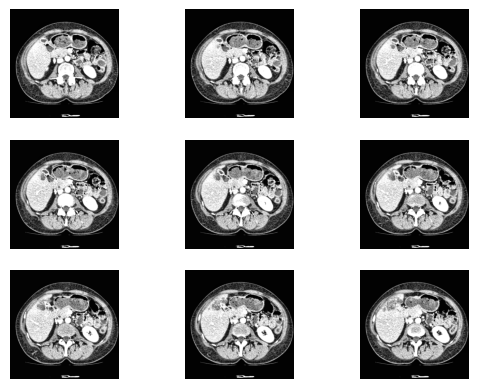

In [33]:
#视觉化展示读取的数据
j = 1
for i in range(0,9):
    plt.subplot(3,3,j)
    plt.imshow(img_patient[i],cmap='gray')
    plt.axis('off')
    j += 1
plt.show()

## 保存肿瘤资料

In [34]:
#设置保存的路径
patient_save_path = r'./tmp/patient'
tumor_save_path = r'./tmp/tumor'
for path in [patient_save_path,tumor_save_path]:
    if os.path.exists(path): #判断资料夹是否存在
        shutil.rmtree(path)#如果存在就清空
    os.makedirs(path)#新增空资料夹用来存放资料

In [35]:
# #保留一个肿瘤的资料
# for i in range(len(img_patient)):
#     plt.imsave(os.path.join(patient_save_path,f'{i}.jpg'),img_patient[i],cmap = 'gray')#CT图
#     plt.imsave(os.path.join(tumor_save_path,f'{i}.jpg'),img_tumor[i],cmap = 'gray')#掩模图

In [36]:
#保存所有的肿瘤资料
livertumor_path = r'./3Dircadb1/3Dircadb1.1/MASKS_DICOM'
#肿瘤路径
tumor_paths = [os.path.join(livertumor_path,i) for i in os.listdir(livertumor_path) if 'livertumor' in i]
tumor_paths.sort()
#提取所有肿瘤资料
j = 0
for tumor_path in tumor_paths:
    print('正在处理第%d个肿瘤'%j)
    #批量数据读取
    tumor_slices = [pydicom.dcmread(os.path.join(tumor_path,file_name)) for file_name in os.listdir(tumor_path)]
    #重新排序,避免CT图乱序
    tumor_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
    #提取图元值
    tumor_array = np.array([i.pixel_array for i in tumor_slices])
    #沒有肿瘤的掩模图全部是黑色,对应的图元矩阵全为0
    index = [i.sum()>0  for i in tumor_array] #提取含肿瘤部分
    #提取掩模图的肿瘤部分
    img_tumor = tumor_array[index]
    #对增強后的CT图提取肿瘤部分
    img_patient = img_clahe[index]
    #保存资料
    for i in range(len(img_patient)):
        plt.imsave(os.path.join(patient_save_path,f'{j}_{i}.jpg'),img_patient[i],cmap = 'gray')#CT图
        plt.imsave(os.path.join(tumor_save_path,f'{j}_{i}.jpg'),img_tumor[i],cmap = 'gray')#掩模图
    j += 1

正在處理第0個腫瘤
正在處理第1個腫瘤
正在處理第2個腫瘤
正在處理第3個腫瘤
正在處理第4個腫瘤
正在處理第5個腫瘤
正在處理第6個腫瘤


## 對所有病人資料做處理

In [37]:
#設置保存的路径
patient_save_path = r'./tmp/patient'
tumor_save_path = r'./tmp/tumor'
for path in [patient_save_path,tumor_save_path]:
    if os.path.exists(path): #判断资料夹是否存在
        shutil.rmtree(path)#如果存在就清空
    os.makedirs(path)#新增空资料夹用来存放资料

In [38]:
for num in range(1,21):
    print('正在处理第%d位元病人的资料'%num)
    #======CT图处理===================
    #读取CT图数据
    data_path = fr'./3Dircadb1/3Dircadb1.{num}/PATIENT_DICOM'
    #批量数据读取
    image_slices = [pydicom.dcmread(os.path.join(data_path,file_name)) for file_name in os.listdir(data_path)]
    os.listdir(data_path)#预设按照字元排序，顺序乱掉了
    #重新排序,避免CT图乱序
    image_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
    #提取图元值
    image_array = np.array([i.pixel_array for i in image_slices])
    #CT图增強-windowing
    img_ct = windowing(image_array,250,0)
    #长条图均衡化
    img_clahe = clahe_equalized(img_ct)
    #=======掩模图处理==================================
    #保存所有的肿瘤资料
    livertumor_path = fr'./3Dircadb1/3Dircadb1.{num}/MASKS_DICOM'
    #肿瘤路径
    tumor_paths = [os.path.join(livertumor_path,i) for i in os.listdir(livertumor_path) if 'livertumor' in i]
    tumor_paths.sort()
    #提取所有肿瘤资料
    j = 0
    for tumor_path in tumor_paths:
        print('正在处理第%d个肿瘤'%j)
        #批量数据读取
        tumor_slices = [pydicom.dcmread(os.path.join(tumor_path,file_name)) for file_name in os.listdir(tumor_path)]
        #重新排序,避免CT图乱序
        tumor_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
        #提取图元值
        tumor_array = np.array([i.pixel_array for i in tumor_slices])
        #沒有肿瘤的掩模图全部是黑色,对应的图元矩阵全为0
        index = [i.sum()>0  for i in tumor_array] #提取含肿瘤部分
        #提取掩模图的肿瘤部分
        img_tumor = tumor_array[index]
        #对增强后的CT图提取肿瘤部分
        img_patient = img_clahe[index]
        #保存资料
        for i in range(len(img_patient)):
            plt.imsave(os.path.join(patient_save_path,f'{num}_{j}_{i}.jpg'),img_patient[i],cmap = 'gray')#CT图
            plt.imsave(os.path.join(tumor_save_path,f'{num}_{j}_{i}.jpg'),img_tumor[i],cmap = 'gray')#掩模图
        j += 1

正在處理第1位元病人的資料
正在處理第0個腫瘤
正在處理第1個腫瘤
正在處理第2個腫瘤
正在處理第3個腫瘤
正在處理第4個腫瘤
正在處理第5個腫瘤
正在處理第6個腫瘤
正在處理第2位元病人的資料
正在處理第0個腫瘤
正在處理第3位元病人的資料
正在處理第0個腫瘤
正在處理第4位元病人的資料
正在處理第0個腫瘤
正在處理第5位元病人的資料
正在處理第6位元病人的資料
正在處理第0個腫瘤
正在處理第7位元病人的資料
正在處理第8位元病人的資料
正在處理第0個腫瘤
正在處理第1個腫瘤
正在處理第2個腫瘤
正在處理第9位元病人的資料
正在處理第0個腫瘤
正在處理第10位元病人的資料
正在處理第0個腫瘤
正在處理第11位元病人的資料
正在處理第12位元病人的資料
正在處理第0個腫瘤
正在處理第13位元病人的資料
正在處理第0個腫瘤
正在處理第14位元病人的資料
正在處理第15位元病人的資料
正在處理第0個腫瘤
正在處理第16位元病人的資料
正在處理第0個腫瘤
正在處理第17位元病人的資料
正在處理第0個腫瘤
正在處理第1個腫瘤
正在處理第18位元病人的資料
正在處理第0個腫瘤
正在處理第19位元病人的資料
正在處理第0個腫瘤
正在處理第20位元病人的資料


# 图像资料增强

In [1]:
import os
import shutil
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import  backend as K
from keras.layers import  *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

## 定义图片生成器

In [2]:
generator_args = dict(
    rotation_range = 0.1,#旋转角度
    width_shift_range = 0.05,#水平移动
    height_shift_range = 0.05,#垂直移动
    shear_range = 0.05,#剪切
    zoom_range = 0.05,#缩放
    horizontal_flip = False,#水平翻转
    vertical_flip = False,#垂直翻转
)
ct_datagen = ImageDataGenerator(generator_args)#CT图片生成器
mask_datagen = ImageDataGenerator(generator_args)#掩模图片生成器

## 图像增强实现

In [4]:
#保存图像增强后图片的路径
save_datagen_path = r'./tmp2'
if os.path.exists(save_datagen_path):
    shutil.rmtree(save_datagen_path)
os.makedirs(save_datagen_path)

In [3]:
#目标路径-ct的增强
generator_path = r'./tmp'
ct_generator = ct_datagen.flow_from_directory(
    generator_path,#目标路径
    classes = ['patient'],#处理的资料夹
    class_mode = None,
    color_mode = 'grayscale',#灰度图
    target_size = (512,512),#图片大小
    batch_size = 2,#图片个数
    #save_to_dir = save_datagen_path,#保存
    save_prefix = 'ct_' ,#增强后图片的首码
    seed = 123,
)
mask_generator = mask_datagen.flow_from_directory(
    generator_path,#目标路径
    classes = ['tumor'],#处理的资料夹
    class_mode = None,
    color_mode = 'grayscale',#灰度图
    target_size = (512,512),#图片大小
    batch_size = 2,#图片个数
    #save_to_dir = save_datagen_path,#保存
    save_prefix = 'mask_' ,#增强后图片的首码
    seed = 123,
)
train_generator = zip(ct_generator,mask_generator)#成组处理

Found 643 images belonging to 1 classes.


Found 643 images belonging to 1 classes.


(512, 512) (2, 512, 512, 1)


c:\Users\xiloyye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


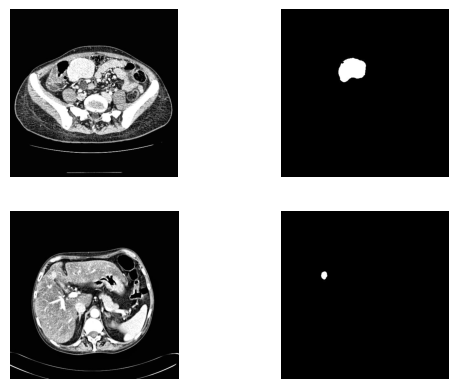

In [4]:
#视觉化
for ct,mask in train_generator:
    print(ct[0][:,:,0].shape,mask.shape)
    plt.subplot(2,2,1)
    plt.imshow(ct[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(mask[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(ct[1][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(mask[1][:,:,0],cmap='gray')
    plt.axis('off')
    
    break
plt.show()

## 图像归一化

In [3]:
def adjust_data(ct,mask):
    #ct： CT图
    #mask：掩模图
    ct = ct/255.0
    mask = mask/255.0
    mask[mask>0.5] = 1#对掩模图做灰度处理
    mask[mask<=0.5] = 0
    return ct,mask

## 整合图像增强的步骤

In [4]:
#自定图像增强函數
def train_generator():
    #======1、定义图像生成器============================
    generator_args = dict(
        rotation_range = 0.1,#旋转角度
        width_shift_range = 0.05,#水平移动
        height_shift_range = 0.05,#垂直移动
        shear_range = 0.05,#剪切
        zoom_range = 0.05,#缩放
        horizontal_flip = False,#水平翻转
        vertical_flip = False,#垂直翻转
    )
    #=====2、分別对CT图和掩模图做图像增强===================================
    ct_datagen = ImageDataGenerator(generator_args)#CT图片生成器
    mask_datagen = ImageDataGenerator(generator_args)#掩模图片生成器
    
    #====3、实现图像增强=====================================================
    generator_path = r'./tmp'
    ct_generator = ct_datagen.flow_from_directory(
        generator_path,#目标路径
        classes = ['patient'],#处理的资料夹
        class_mode = None,
        color_mode = 'grayscale',#灰度图
        target_size = (512,512),#图片大小
        batch_size = 2,#图片个数
        #save_to_dir = save_datagen_path,#保存
        #save_prefix = 'ct_' ,#增强后图片的首码
        seed = 123,
    )
    mask_generator = mask_datagen.flow_from_directory(
        generator_path,#目标路径
        classes = ['tumor'],#处理的资料夹
        class_mode = None,
        color_mode = 'grayscale',#灰度图
        target_size = (512,512),#图片大小
        batch_size = 2,#图片个数
        #save_to_dir = save_datagen_path,#保存
        #save_prefix = 'mask_' ,#增强后图片的首码
        seed = 123,
    )
    train_generator = zip(ct_generator,mask_generator)#成组处理
    #============4、归一化处理==========================
    for (ct,mask) in train_generator:
        yield adjust_data(ct,mask)

Found 643 images belonging to 1 classes.


Found 643 images belonging to 1 classes.
(512, 512) (2, 512, 512, 1)


c:\Users\xiloyye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


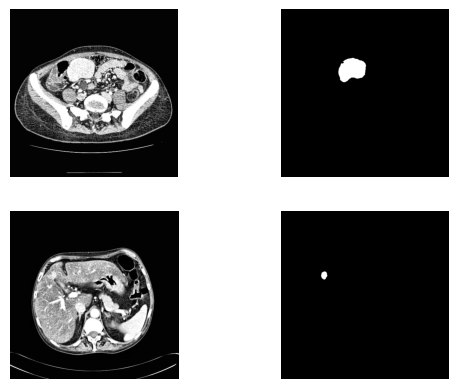

In [5]:
gene = train_generator() #模型的输入和输出，可以直接放在模型的训练里面
#视觉化
for ct,mask in gene:
    print(ct[0][:,:,0].shape,mask.shape)
    plt.subplot(2,2,1)
    plt.imshow(ct[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(mask[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(ct[1][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(mask[1][:,:,0],cmap='gray')
    plt.axis('off')
    
    break
plt.show()

# 搭建模型

## 搭建模型

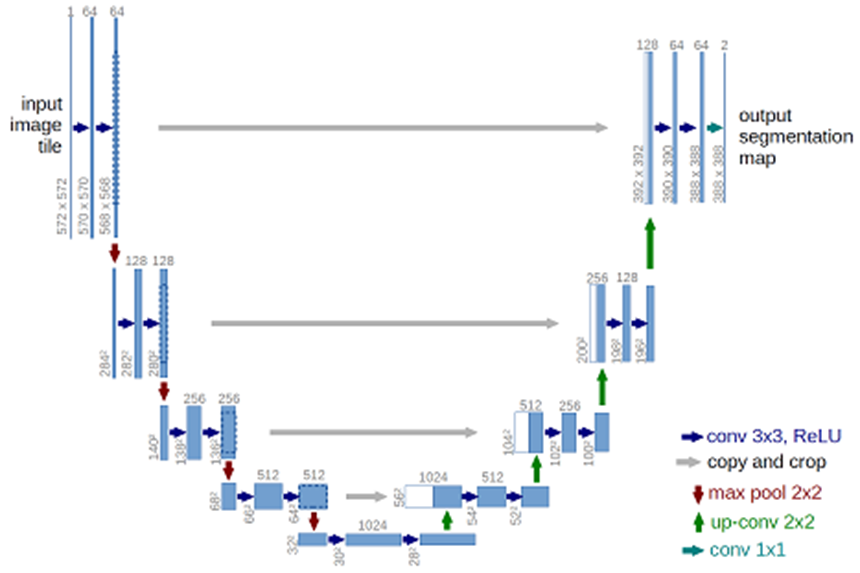

In [9]:
# from tensorflow.keras import  backend as K
# from tensorflow.keras.layers import  *
K.clear_session()
model_path = r'./tmp/model.h5'
'''### 定义 Dice Coefficient Loss 函数
def dice_coef_loss(y_true, y_pred, smooth=1):
    """
    计算 Dice Coefficient Loss
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    dice_loss = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1. - dice_loss

### 定义 Dice Coefficient 函数
def dice_coef(y_true, y_pred, smooth=1):
    """
    计算 Dice Coefficient
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(tf.multiply(y_true_f, y_pred_f))
    dice_coeff = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice_coeff'''
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
def u_net(input_size=(512,512,1),path = model_path):
    inputs = Input(input_size)
    conv1 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(inputs)
    conv2 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPool2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    conv4 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv3)
    pool2 = MaxPool2D(pool_size=(2,2))(conv4)
    
    conv5 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    conv6 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv5)
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    
    conv7 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    conv8 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv7)
    pool4 = MaxPool2D(pool_size=(2,2))(conv8)
    
    conv9 = Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    conv10 = Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv9)
    up1 = UpSampling2D((2,2))(conv10)#反卷积
    
    conv11 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up1,conv8],axis=3))#开始右半部分
    conv12 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv11)
    up2 = UpSampling2D((2,2))(conv12)#反卷积
    
    conv13 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up2,conv6],axis=3))
    conv14 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv13)
    up3 = UpSampling2D((2,2))(conv14)#反卷积
    
    conv15 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up3,conv4],axis=3))
    conv16 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv15)
    up4 = UpSampling2D((2,2))(conv16)#反卷积
    
    conv17 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up4,conv2],axis=3))
    conv18 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv17)
    out = Conv2D(1,1,activation='sigmoid')(conv18)
    
    model = tf.keras.Model(inputs = inputs,outputs = out)#搭建模型
    model.compile(loss=dice_coef_loss,optimizer='adam',metrics=[dice_coef])#模型编译
    #model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])#模型编译
    #model.summary()
    return model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape = (512,512,1)):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)


    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = tf.keras.Model(inputs, outputs, name="UNET")
    return model

In [10]:
#model = u_net()
model = build_unet()
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

## 模型训练

Epoch 1/20
80/80 [==============================] - ETA: 0s - loss: 0.9399 - dice_coef: 0.0601 
Epoch 1: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


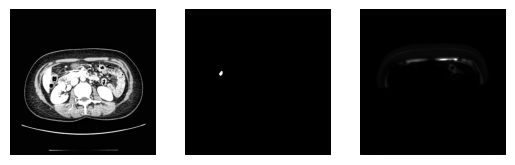

80/80 [==============================] - 816s 10s/step - loss: 0.9399 - dice_coef: 0.0601
Epoch 2/20
80/80 [==============================] - ETA: 0s - loss: 0.9218 - dice_coef: 0.0787 
Epoch 2: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


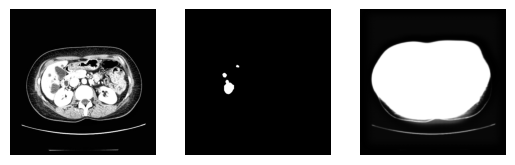

80/80 [==============================] - 808s 10s/step - loss: 0.9218 - dice_coef: 0.0787
Epoch 3/20
80/80 [==============================] - ETA: 0s - loss: 0.8695 - dice_coef: 0.1305 
Epoch 3: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


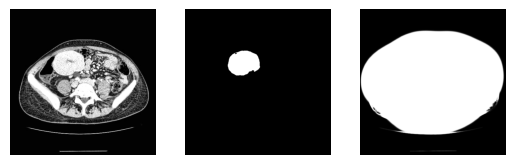

80/80 [==============================] - 808s 10s/step - loss: 0.8695 - dice_coef: 0.1305
Epoch 4/20
80/80 [==============================] - ETA: 0s - loss: 0.8599 - dice_coef: 0.1401 
Epoch 4: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


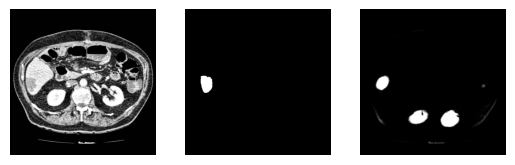

80/80 [==============================] - 802s 10s/step - loss: 0.8599 - dice_coef: 0.1401
Epoch 5/20
80/80 [==============================] - ETA: 0s - loss: 0.7503 - dice_coef: 0.2497
Epoch 5: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


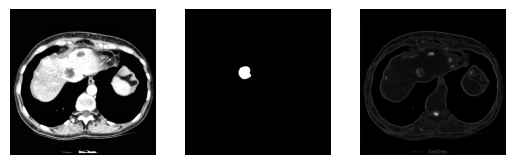

80/80 [==============================] - 801s 10s/step - loss: 0.7503 - dice_coef: 0.2497
Epoch 6/20
80/80 [==============================] - ETA: 0s - loss: 0.7551 - dice_coef: 0.2433
Epoch 6: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


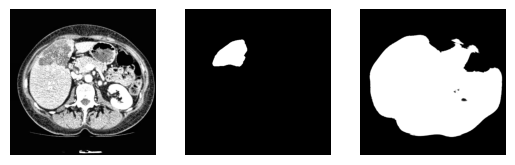

80/80 [==============================] - 799s 10s/step - loss: 0.7551 - dice_coef: 0.2433
Epoch 7/20
80/80 [==============================] - ETA: 0s - loss: 0.7999 - dice_coef: 0.2001 
Epoch 7: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


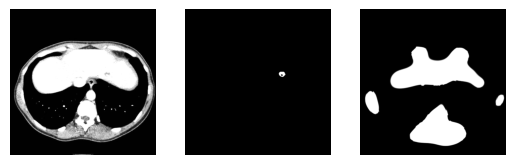

80/80 [==============================] - 803s 10s/step - loss: 0.7999 - dice_coef: 0.2001
Epoch 8/20
80/80 [==============================] - ETA: 0s - loss: 0.7716 - dice_coef: 0.2284
Epoch 8: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


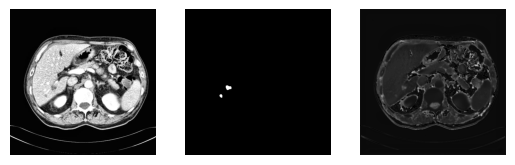

80/80 [==============================] - 801s 10s/step - loss: 0.7716 - dice_coef: 0.2284
Epoch 9/20
80/80 [==============================] - ETA: 0s - loss: 0.7884 - dice_coef: 0.2116
Epoch 9: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


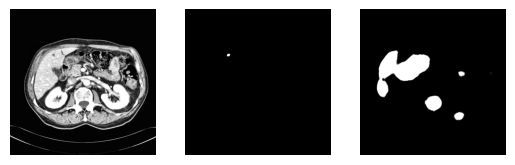

80/80 [==============================] - 801s 10s/step - loss: 0.7884 - dice_coef: 0.2116
Epoch 10/20
80/80 [==============================] - ETA: 0s - loss: 0.9775 - dice_coef: 0.0223
Epoch 10: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


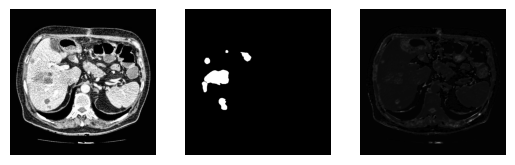

80/80 [==============================] - 797s 10s/step - loss: 0.9775 - dice_coef: 0.0223
Epoch 11/20
80/80 [==============================] - ETA: 0s - loss: 0.9892 - dice_coef: 0.0108
Epoch 11: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


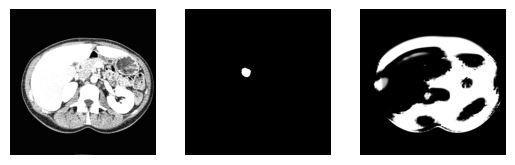

80/80 [==============================] - 800s 10s/step - loss: 0.9892 - dice_coef: 0.0108
Epoch 12/20
80/80 [==============================] - ETA: 0s - loss: 0.8261 - dice_coef: 0.1739
Epoch 12: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


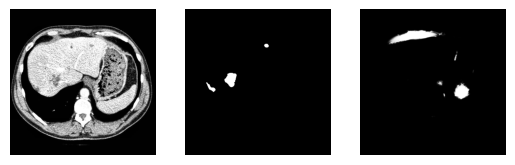

80/80 [==============================] - 801s 10s/step - loss: 0.8261 - dice_coef: 0.1739
Epoch 13/20
80/80 [==============================] - ETA: 0s - loss: 0.7105 - dice_coef: 0.2895
Epoch 13: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


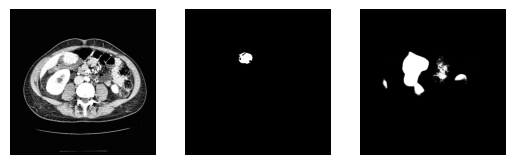

80/80 [==============================] - 801s 10s/step - loss: 0.7105 - dice_coef: 0.2895
Epoch 14/20
80/80 [==============================] - ETA: 0s - loss: 0.7175 - dice_coef: 0.2808
Epoch 14: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


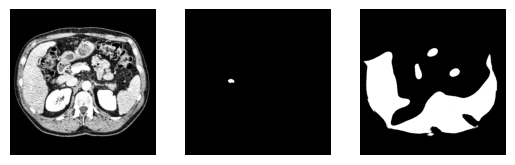

80/80 [==============================] - 798s 10s/step - loss: 0.7175 - dice_coef: 0.2808
Epoch 15/20
80/80 [==============================] - ETA: 0s - loss: 0.7438 - dice_coef: 0.2562 
Epoch 15: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


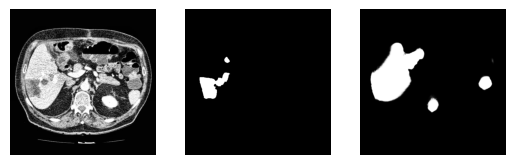

80/80 [==============================] - 801s 10s/step - loss: 0.7438 - dice_coef: 0.2562
Epoch 16/20
80/80 [==============================] - ETA: 0s - loss: 0.6916 - dice_coef: 0.3084 
Epoch 16: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


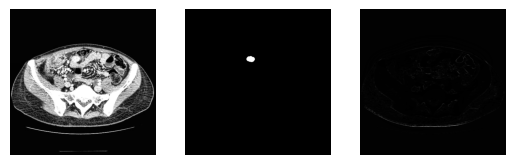

80/80 [==============================] - 803s 10s/step - loss: 0.6916 - dice_coef: 0.3084
Epoch 17/20
80/80 [==============================] - ETA: 0s - loss: 0.6776 - dice_coef: 0.3224 
Epoch 17: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


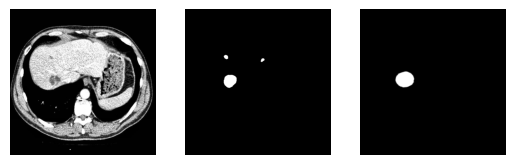

80/80 [==============================] - 803s 10s/step - loss: 0.6776 - dice_coef: 0.3224
Epoch 18/20
80/80 [==============================] - ETA: 0s - loss: 0.6873 - dice_coef: 0.3140
Epoch 18: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


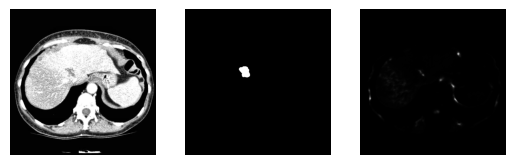

80/80 [==============================] - 798s 10s/step - loss: 0.6873 - dice_coef: 0.3140
Epoch 19/20
80/80 [==============================] - ETA: 0s - loss: 0.7068 - dice_coef: 0.2932 
Epoch 19: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


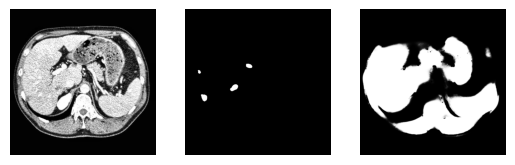

80/80 [==============================] - 803s 10s/step - loss: 0.7068 - dice_coef: 0.2932
Epoch 20/20
80/80 [==============================] - ETA: 0s - loss: 0.6633 - dice_coef: 0.3367 
Epoch 20: saving model to ./tmp\model.h5

1/1 [==============================] - 1s 1s/step


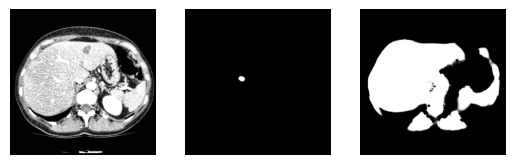

80/80 [==============================] - 802s 10s/step - loss: 0.6633 - dice_coef: 0.3367


In [16]:
model_path = r'./tmp/model.h5'
model_ckpt = ModelCheckpoint(model_path,save_best_only=False,verbose=1)

class ShowMask(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch, logs=None):
        print()
        for ct, mask in gene:
            plt.subplot(1, 3, 1)
            plt.imshow(ct[0], cmap='gray')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0], cmap='gray')
            plt.axis('off')  
            plt.subplot(1, 3, 3)
            plt.imshow(model.predict(ct[0].reshape(1, 512, 512, 1))[0], cmap='gray')
            plt.axis('off')  
            plt.show()
            break

batch_size = 8  # 自定义批次大小
steps_per_epoch = 643//batch_size  # 自定义每个epoch的步骤数
num_epochs = 20  # 自定义epoch数
model.compile(loss=dice_coef_loss,optimizer='adam',metrics=[dice_coef])
model.fit(gene, batch_size=batch_size, steps_per_epoch=steps_per_epoch, epochs=num_epochs, callbacks=[model_ckpt,ShowMask()], verbose=1)
#model.fit(gene,steps_per_epoch=50,epochs=4,callbacks=[model_ckpt,ShowMask()],verbose=1)

Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 0.1961 - dice_coef: 0.8039 
Epoch 1: saving model to ./tmp\model.h5

1/1 [==============================] - 2s 2s/step


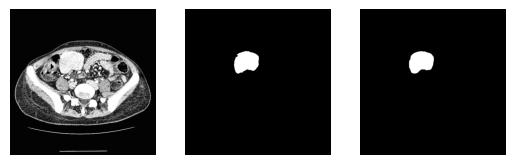

80/80 [==============================] - 1012s 13s/step - loss: 0.1961 - dice_coef: 0.8039
Epoch 2/10
80/80 [==============================] - ETA: 0s - loss: 0.2118 - dice_coef: 0.7886 
Epoch 2: saving model to ./tmp\model.h5

1/1 [==============================] - 2s 2s/step


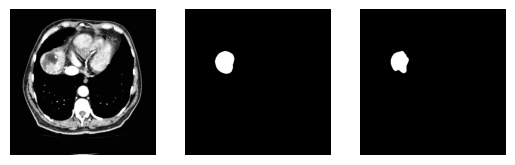

80/80 [==============================] - 994s 12s/step - loss: 0.2118 - dice_coef: 0.7886
Epoch 3/10
80/80 [==============================] - ETA: 0s - loss: 0.1973 - dice_coef: 0.8027 
Epoch 3: saving model to ./tmp\model.h5

1/1 [==============================] - 2s 2s/step


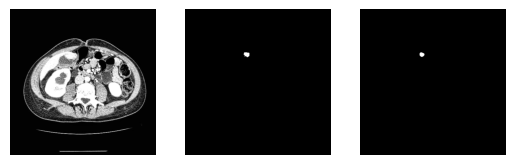

80/80 [==============================] - 990s 12s/step - loss: 0.1973 - dice_coef: 0.8027
Epoch 4/10
80/80 [==============================] - ETA: 0s - loss: 0.1839 - dice_coef: 0.8161 
Epoch 4: saving model to ./tmp\model.h5

1/1 [==============================] - 2s 2s/step


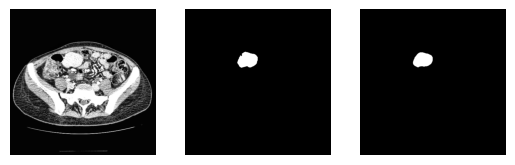

80/80 [==============================] - 989s 12s/step - loss: 0.1839 - dice_coef: 0.8161
Epoch 5/10
80/80 [==============================] - ETA: 0s - loss: 0.2030 - dice_coef: 0.7970 
Epoch 5: saving model to ./tmp\model.h5

1/1 [==============================] - 2s 2s/step


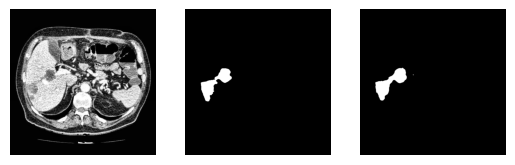

80/80 [==============================] - 988s 12s/step - loss: 0.2030 - dice_coef: 0.7970
Epoch 6/10
80/80 [==============================] - ETA: 0s - loss: 0.1977 - dice_coef: 0.7973 
Epoch 6: saving model to ./tmp\model.h5

1/1 [==============================] - 2s 2s/step


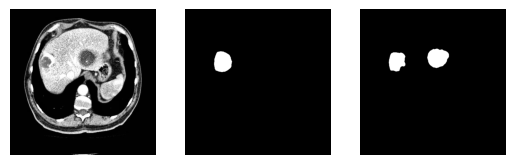

80/80 [==============================] - 992s 12s/step - loss: 0.1977 - dice_coef: 0.7973
Epoch 7/10
80/80 [==============================] - ETA: 0s - loss: 0.1986 - dice_coef: 0.8014 
Epoch 7: saving model to ./tmp\model.h5

1/1 [==============================] - 2s 2s/step


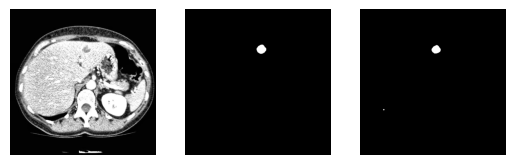

80/80 [==============================] - 984s 12s/step - loss: 0.1986 - dice_coef: 0.8014
Epoch 8/10
70/80 [=========================>....] - ETA: 2:05 - loss: 0.1882 - dice_coef: 0.8118

KeyboardInterrupt: 

In [11]:
from keras.models import load_model
model_path = r'./tmp/model.h5'
model_ckpt = ModelCheckpoint(model_path,save_best_only=False,verbose=1)

class ShowMask(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch, logs=None):
        print()
        for ct, mask in gene:
            plt.subplot(1, 3, 1)
            plt.imshow(ct[0], cmap='gray')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0], cmap='gray')
            plt.axis('off')  
            plt.subplot(1, 3, 3)
            plt.imshow(loaded_model.predict(ct[0].reshape(1, 512, 512, 1))[0], cmap='gray')
            plt.axis('off')  
            plt.show()
            break

batch_size = 8  # 自定义批次大小
steps_per_epoch = 643//batch_size  # 自定义每个epoch的步骤数
num_epochs = 10  # 自定义epoch数
# 加载模型
loaded_model = load_model(model_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
# 继续训练模型
loaded_model.fit(gene, batch_size=batch_size, steps_per_epoch=steps_per_epoch, epochs=num_epochs, callbacks=[model_ckpt, ShowMask()], verbose=1)

In [10]:
# 对每个批次进行预测，并计算 Dice Coefficient
from keras.models import load_model
model_path = r'./tmp/model.h5'
loaded_model = load_model(model_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
dice_coef_list = []
for X_batch, y_batch in gene:
    y_pred = loaded_model.predict(X_batch, verbose=0)
    dice_coef_batch = dice_coef(y_batch, y_pred)
    dice_coef_list.append(dice_coef_batch)
    if len(dice_coef_list) == 643:
        break

# 计算平均 Dice Coefficient
mean_dice_coef = np.mean(dice_coef_list)
print('Mean Dice Coefficient:', mean_dice_coef)

Mean Dice Coefficient: 0.8061671


## 模型预测

1/1 [==============================] - 1s 1s/step


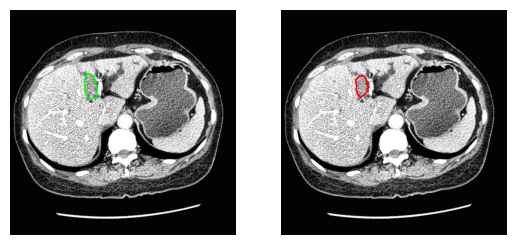

In [27]:
patient_id = '3_0_13'
# 1.1读取病人的CT图（tmp资料夹，已经做了windowing、长条图均衡化）
patient_ct = cv2.imread(f'./tmp/patient/{patient_id}.jpg')
# 1.2读取病人掩膜图
patient_mask = cv2.imread(f'./tmp/tumor/{patient_id}.jpg', cv2.IMREAD_GRAYSCALE)


# 2.1模型载入（已经训练好的模型）
#model_test = tf.keras.models.load_model('./tmp/model.h5')
model_test = tf.keras.models.load_model('./tmp/model.h5', custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef': dice_coef})
# 2.2 模型输入的处理
# 2.2.1 灰度处理
ct_gray = cv2.cvtColor(patient_ct, cv2.COLOR_BGR2GRAY)
# 2.2.2 数据形狀（batch_size, img_height, img_height, img_channel_size）
ct_gray = ct_gray.reshape((1, 512, 512, 1))
# 2.2.3 归一化
ct_gray = ct_gray/ 255.
# 2.3 模型预测
pred_mask = model_test.predict(ct_gray)[0]

# 3结果展示
_, patient_mask = cv2.threshold(patient_mask, 127, 255, 0)
# 3.1轮廓线提取
contours, _ = cv2.findContours(patient_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# 3.2在CT图上绘制轮廓线
overlap_img = cv2.drawContours(patient_ct.copy(), contours, -1, (0, 255, 0), 2)
# 3.3 展示
#cv2.imshow('real', overlap_img)
#cv2.waitKey(0)
plt.subplot(1, 2, 1)
plt.imshow(overlap_img)
plt.axis('off')

# 3结果展示
_, bi_mask = cv2.threshold((pred_mask*255).astype('uint8'), 127, 255, 0)
# 3.1轮廓线提取
contours, _ = cv2.findContours(bi_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# 3.2在CT图上绘制轮廓线
overlap_img2 = cv2.drawContours(patient_ct.copy(), contours, -1, (255, 0, 0), 2)
# 3.3 展示
#cv2.imshow('predict', overlap_img2)
#cv2.waitKey(0)
plt.subplot(1, 2, 2)
plt.imshow(overlap_img2)
plt.axis('off')
plt.show()